## ANN modeling

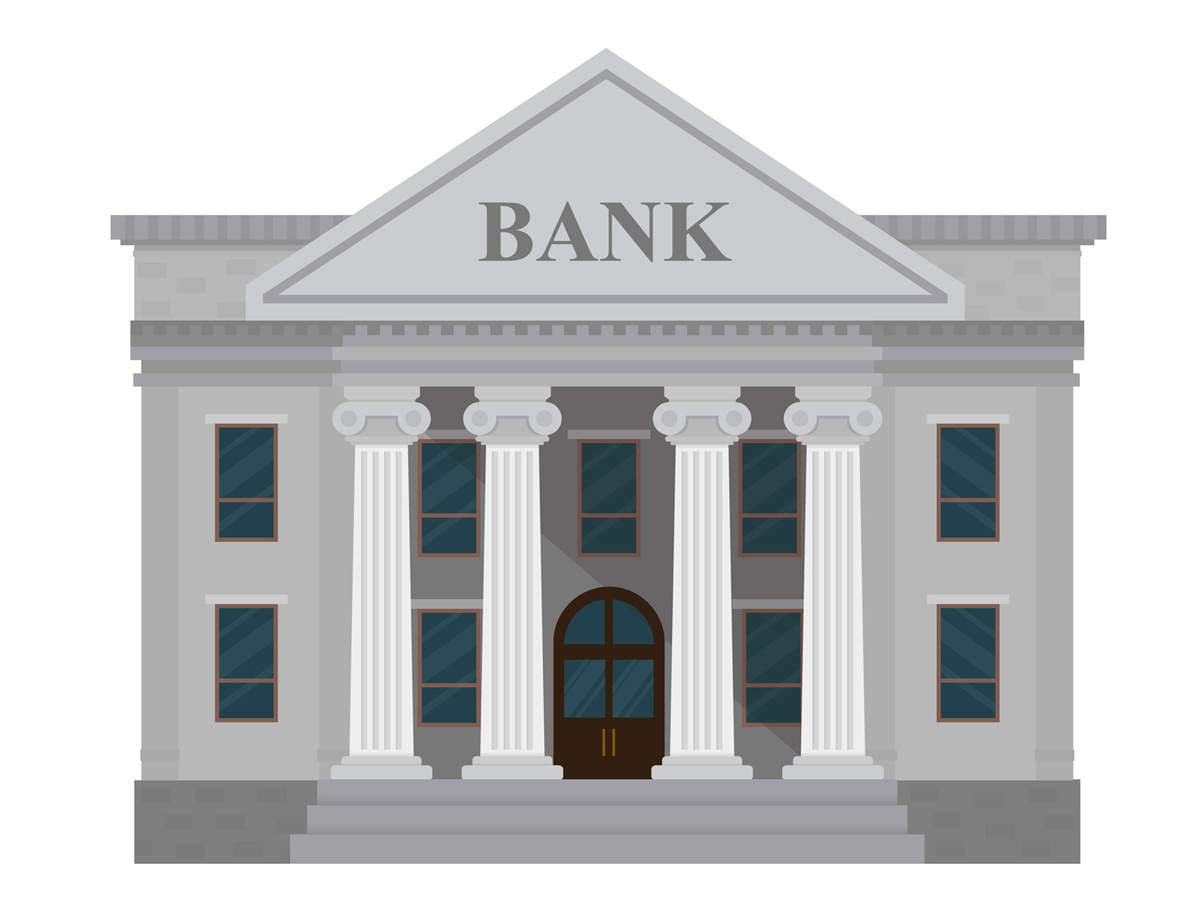

The objective of this analysis is to see whether a customer will stop having an account in a bank, using NN in the process.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import geopandas as gpd

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc

from keras.models import Sequential # Initializing ANN
from keras.layers import Dense, Dropout # Layers and dropout to avoid overfitting
sns.set()

%matplotlib inline

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('Churn_Modelling.csv')
dataset.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [3]:
dataset.describe().T

count          mean           std          min  \
RowNumber        10000.0  5.000500e+03   2886.895680         1.00   
CustomerId       10000.0  1.569094e+07  71936.186123  15565701.00   
CreditScore      10000.0  6.505288e+02     96.653299       350.00   
Age              10000.0  3.892180e+01     10.487806        18.00   
Tenure           10000.0  5.012800e+00      2.892174         0.00   
Balance          10000.0  7.648589e+04  62397.405202         0.00   
NumOfProducts    10000.0  1.530200e+00      0.581654         1.00   
HasCrCard        10000.0  7.055000e-01      0.455840         0.00   
IsActiveMember   10000.0  5.151000e-01      0.499797         0.00   
EstimatedSalary  10000.0  1.000902e+05  57510.492818        11.58   
Exited           10000.0  2.037000e-01      0.402769         0.00   

                         25%           50%           75%          max  
RowNumber            2500.75  5.000500e+03  7.500250e+03     10000.00  
CustomerId       15628528.25  1.569074e+07  1.575323e+07  15815690.00  
CreditScore           584.00  6.520000e+02  7.180000e+02       850.00  
Age                    32.00  3.700000e+01  4.400000e+01        92.00  
Tenure                  3.00  5.000000e+00  7.000000e+00        10.00  
Balance                 0.00  9.719854e+04  1.276442e+05    250898.09  
NumOfProducts           1.00  1.000000e+00  2.000000e+00         4.00  
HasCrCard               0.00  1.000000e+00  1.000000e+00         1.00  
IsActiveMember          0.00  1.000000e+00  1.000000e+00         1.00  
EstimatedSalary     51002.11  1.001939e+05  1.493882e+05    199992.48  
Exited                  0.00  0.000000e+00  0.000000e+00         1.00

**The set has:**
- Info of 1000 different customers.
- Three categorical columns: 'Surname', 'Geography' and 'Gender'. Surname will be dropped as it doesn't give any additional information.
- 11 numerical columns, two of them will be dropped, as 'Row Number' and 'Customer Id' don't give any useful info.

**Checking missing values**

In [4]:
print(pd.isnull(dataset).sum()) # Is there any missing value?

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


There are no missing values in the set.

In [5]:
dataset2 = dataset.copy() # Copying before dropping columns
dataset2 = dataset2.drop(['Surname','RowNumber','CustomerId'], axis = 1) 

## EDA and visualizations

**Gender and age**

In [6]:
Genre = pd.DataFrame(dataset2['Gender'].value_counts()).reset_index()
Genre.columns = ['Gender','Total']
fig = px.pie(Genre, values = 'Total', names = 'Gender', title='Gender percentage', hole=.4, color = 'Gender',width=800, height=400)
fig.show()

In [7]:
fig = px.bar(Genre, x = 'Gender', y='Total', title='Amount per genre', color='Gender',width=600, height=500)
fig.show()

In [8]:
Male = dataset2[dataset2["Gender"] == 'Male'][['Gender','Age','EstimatedSalary']]
temp = pd.DataFrame(Male['Age'].value_counts().reset_index())
temp.columns = ['Age','Total']

Female = dataset2[dataset2["Gender"] == 'Female'][['Gender','Age','EstimatedSalary']]
temp2 = pd.DataFrame(Female['Age'].value_counts().reset_index())
temp2.columns = ['Age','Total']

In [9]:
hist_data = [Male['Age'],Female['Age']]
group_labels = ['Male Age','Female Age']

fig = ff.create_distplot(hist_data, group_labels, bin_size=[5,5], colors = ['Blue', 'Red'])
fig.update_layout(title_text='Male and Female age distribution')
fig.show()

In [10]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x = temp['Age'],
    y = temp['Total'],
    name='Male',
    marker_color='rgba(94, 144, 175, 0.8)'
))
fig.add_trace(go.Bar(
    x = temp2['Age'],
    y = temp2['Total'],
    name='Female',
    marker_color='rgba(249, 70, 10, 0.9)'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(title = 'Age per genre', barmode = 'group', xaxis_tickangle=-45)
fig.show()

## Exited members

In [11]:
Exited = dataset2.query('Exited == 1')

Male = Exited[Exited["Gender"] == 'Male'][['Gender','Age','EstimatedSalary']]
temp = pd.DataFrame(Male['Age'].value_counts().reset_index())
temp.columns = ['Age','Total']

Female = Exited[Exited["Gender"] == 'Female'][['Gender','Age','EstimatedSalary']]
temp2 = pd.DataFrame(Female['Age'].value_counts().reset_index())
temp2.columns = ['Age','Total']

In [12]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x = temp['Age'],
    y = temp['Total'],
    name='Male',
    marker_color='rgba(94, 144, 175, 0.8)'
))
fig.add_trace(go.Bar(
    x = temp2['Age'],
    y = temp2['Total'],
    name='Female',
    marker_color='rgba(249, 70, 10, 0.9)'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(title = 'Exited members', barmode = 'group', xaxis_tickangle=-45)
fig.show()

In [13]:
Exited_value = pd.DataFrame(Exited['Gender'].value_counts()).reset_index()
Exited_value.columns = ['Gender','Total']

fig = px.pie(Exited_value, values = 'Total', names = 'Gender', title='Exited gender percentage', hole=.4, color = 'Gender',width=800, height=400)
fig.show()

In [14]:
Product = Exited['NumOfProducts'].value_counts()
Product = pd.DataFrame(Product).reset_index() # Creating DF
Product.columns = ['NumOfProducts','Total']

In [15]:
fig = px.bar(Product, x = 'NumOfProducts', y = 'Total' ,
             hover_data = ['NumOfProducts','Total'] , color='NumOfProducts', height=400, title = 'Exited members and prouts')
fig.show()

In [16]:
CreditCard = Exited['HasCrCard'].value_counts()
CreditCard = pd.DataFrame(CreditCard).reset_index() # Creating DF
CreditCard.columns = ['CreditCard','Total']

fig = px.bar(CreditCard, x = 'CreditCard', y = 'Total' ,
             hover_data = ['CreditCard','Total'] , color='CreditCard', height=400, title = 'Exited members and credit card')
fig.show()

In [17]:
Active = Exited['IsActiveMember'].value_counts()
Active = pd.DataFrame(Active).reset_index() # Creating DF
Active.columns = ['Active','Total']

fig = px.bar(Active, x = 'Active', y = 'Total' ,
             hover_data = ['Active','Total'] , color='Active', height=400, title = 'Active exited members')
fig.show()

In [18]:
Tenure = Exited['Tenure'].value_counts()
Tenure = pd.DataFrame(Tenure).reset_index() # Creating DF
Tenure.columns = ['Tenure','Total']

fig = px.bar(Tenure, x = 'Tenure', y = 'Total' ,
             hover_data = ['Tenure','Total'] , color='Tenure', height=400, title = 'Exited members and tenure')
fig.show()

## Credit score

In [19]:
Non_Exited = dataset2.query('Exited == 0')

hist_data = [Exited['CreditScore'], Non_Exited['CreditScore']]
group_labels = [ 'Exited Credit Score','Non Exited Credit Score']

fig = ff.create_distplot(hist_data, group_labels, bin_size=[10, 10], colors = ['#F66095', '#2BCDC1'])
fig.update_layout(title_text='Credit score')
fig.show()

Exited members credit score has a normal distribution around a lower value than non exited ones. Non Exited members have higher credit scores.

**Conclusions:**
- There are more men than women in the bank dataset, and both they ages are normally distributed around 36 years.
- As expected, most of the bank products are directed for people mostly from 25 to 45 years.
- 56% of exited members are women, men are more loyal to the bank.
- Most exited members had only 1 product in the bank and having credit card didn't affect them in their decission.
- Most exited members were unnactive.
- The number of tenures is not decisive for leaving the bank.

## Countries

In [20]:
Europe = gpd.read_file('Europe.shp')
Europe = Europe.drop(['ORGN_NAME'], axis = 1)
Europe.head()

NAME                                           geometry
0             Albania  MULTIPOLYGON (((19.50115 40.96230, 19.50563 40...
1             Andorra  POLYGON ((1.43992 42.60649, 1.45041 42.60596, ...
2             Austria  POLYGON ((16.00000 48.77775, 16.00000 48.78252...
3             Belgium  POLYGON ((5.00000 49.79374, 4.99724 49.79696, ...
4  Bosnia Herzegovina  POLYGON ((19.22947 43.53458, 19.22925 43.53597...

In [21]:
Countries = pd.DataFrame(Exited['Geography'].value_counts())

Temp = Countries.index.to_frame(index=False, name = 'Country')
Temp2 = Countries.reset_index(drop = True)
Temp2 = Temp2.rename(columns={'Geography': 'Exited'})
Temp3 = Temp.join(Temp2)
Temp3.head(10).style.background_gradient(cmap='YlOrRd')

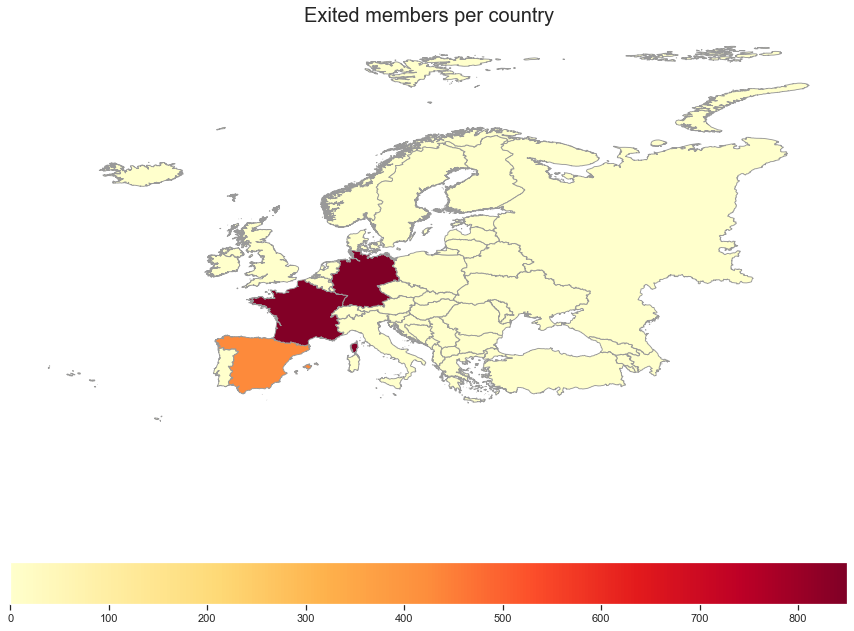

In [22]:
mapped = Europe.set_index('NAME').join(Temp3.set_index('Country')).reset_index()
mapped['Exited'] = mapped['Exited'].fillna(0)

to_be_mapped = 'Exited'
vmin, vmax = 0,850
fig, ax = plt.subplots(1, figsize=(15,15))

mapped.dropna().plot(column=to_be_mapped, cmap='YlOrRd', linewidth=0.9, ax=ax, edgecolors='0.6')
ax.set_title('Exited members per country', fontdict={'fontsize':20})
ax.set_axis_off()

sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []

cbar = fig.colorbar(sm, orientation='horizontal')

Most exited members are from Germany and France! Followed by Spain.

## Correlation Matrix

Gender and geography are important features for predicting an exited member, so I'll not encode them yet.

Let's see the correlation between numerical features.

In [23]:
x = ["CreditScore", "Age", "Tenure","Balance", "NumOfProducts", "HasCrCard","IsActiveMember","EstimatedSalary","Exited"]
heat = go.Heatmap(z =dataset2.corr(),
                  x = x,
                  y=x,
                  xgap=1, ygap=1,
                  colorbar_thickness=20,
                  colorbar_ticklen=3,
                  hovertext = dataset2.corr(),
                  hoverinfo='text',colorscale=[[0.0, '#F5FFFA'], 
                         [0.2, '#ADD8E6'], 
                         [0.4, '#87CEEB'],
                         [0.6, '#87CEFA'], 
                         [0.8, '#40E0D0'], 
                         [1.0, '#00CED1']]
                   )

title = 'Correlation Matrix'               

layout = go.Layout(title_text=title, title_x=0.5, 
                   width=600, height=600,
                   xaxis_showgrid=False,
                   yaxis_showgrid=False,
                   yaxis_autorange='reversed')
   
fig=go.Figure(data=[heat], layout=layout)        
fig.show() 

'IsActiveMember' and 'Age' are the best predictors for an exited member as well as the categorical features.

## Feature Engineering

**OHE for categorical columns**

In [24]:
data_dummie = pd.get_dummies(dataset2)

As I'll create a simple NN, first the dataset will be **scaled.** The accuracy of ANN improves considerably when scaling the data accordingly.

In [25]:
MinMaxScaler = MinMaxScaler() 
data_dummie_Scaled = MinMaxScaler.fit_transform(data_dummie)
data_dummie_Scaled = pd.DataFrame(data_dummie_Scaled, columns = data_dummie.columns)
data_dummie_Scaled.head(3)

CreditScore       Age  Tenure   Balance  NumOfProducts  HasCrCard  \
0        0.538  0.324324     0.2  0.000000       0.000000        1.0   
1        0.516  0.310811     0.1  0.334031       0.000000        0.0   
2        0.304  0.324324     0.8  0.636357       0.666667        1.0   

   IsActiveMember  EstimatedSalary  Exited  Geography_France  \
0             1.0         0.506735     1.0               1.0   
1             1.0         0.562709     0.0               0.0   
2             0.0         0.569654     1.0               1.0   

   Geography_Germany  Geography_Spain  Gender_Female  Gender_Male  
0                0.0              0.0            1.0          0.0  
1                0.0              1.0            1.0          0.0  
2                0.0              0.0            1.0          0.0

**Splitting dataset**

In [26]:
X = data_dummie_Scaled.drop(['Exited'], axis = 1).values
y = data_dummie_Scaled['Exited'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## NN modeling

An **artificial neural network (ANN)** is the piece of a computing system designed to simulate the way the human brain analyzes and processes information. It is the foundation of artificial intelligence (AI) and solves problems that would prove impossible or difficult by human or statistical standards. ANNs have self-learning capabilities that enable them to produce better results as more data becomes available.

**Perceptron is a single layer neural network**, it consists of a **layer of inputs(corresponds to columns of a dataframe)**. Each input has a weight which controls the magnitude of an input. The summation of the products of these input values and weights is fed to the activation function. Activation functions are really important for a Artificial Neural Network to learn and make sense of something really complicated and Non-linear complex functional mappings between the inputs and response variable.

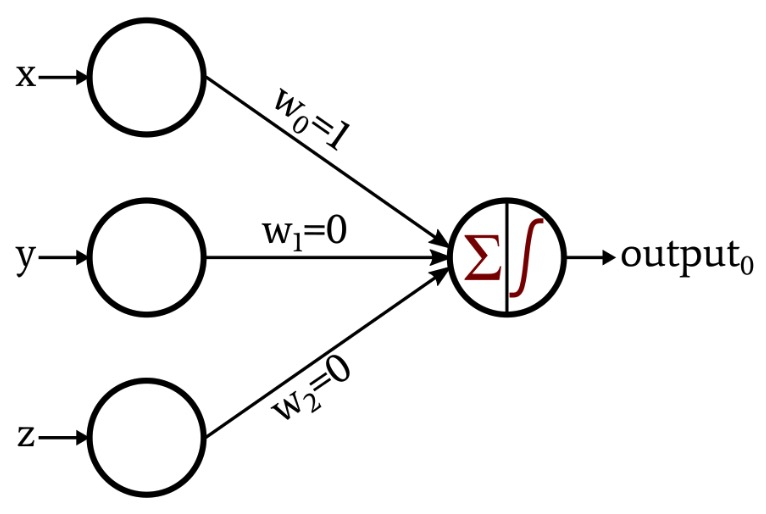

**Artificial neural network**, which has input layer, output layer, and **two or more trainable weight layers** (constisting of Perceptrons) is called multilayer perceptron or **MLP.**

Information flows through a neural network in two ways. When it's learning (being trained) or operating normally (after being trained), patterns of information are fed into the network via the input units, which trigger the layers of hidden units, and these in turn arrive at the output units. This common design is called a **feedforward network.**

**Backpropagation**

By a feedback process called backpropagation, the network compares the predicted output with the real output value, and it uses this difference to learn and update it's weights.

## Initializing NN sequential model

In [27]:
classifier = Sequential() # Initializing model

## Adding layers

## Input Layer

In [28]:
classifier.add(Dense(units = 7, activation = 'relu', input_dim = X_train.shape[1], kernel_initializer = "glorot_uniform")) 
classifier.add(Dropout(rate = 0.1))

For the number of units (input nodes) , I'll select the number of final outputs (1), add the number of input_dim (number of features to enter the network, in this case 13) and half that number.

In this case I'll use 7 units. This is an iterative process, and trial and error is the best way to optimize the number of nodes and layers.

## Initializer

The aim of **weight initialization** is to **prevent layer activation outputs from exploding or vanishing during the course of a forward pass through a deep neural network.** If either occurs, loss gradients will either be too large or too small to flow backwards beneficially, and the network will take longer to converge, if it is even able to do so at all.

There are many initializers that could be used in Keras: Glorot uniform (default), uniform and glorot normal among others. Also this initializer is a trial and error procedure.

Bias will be initialized in 0 (default)

**Activation function**

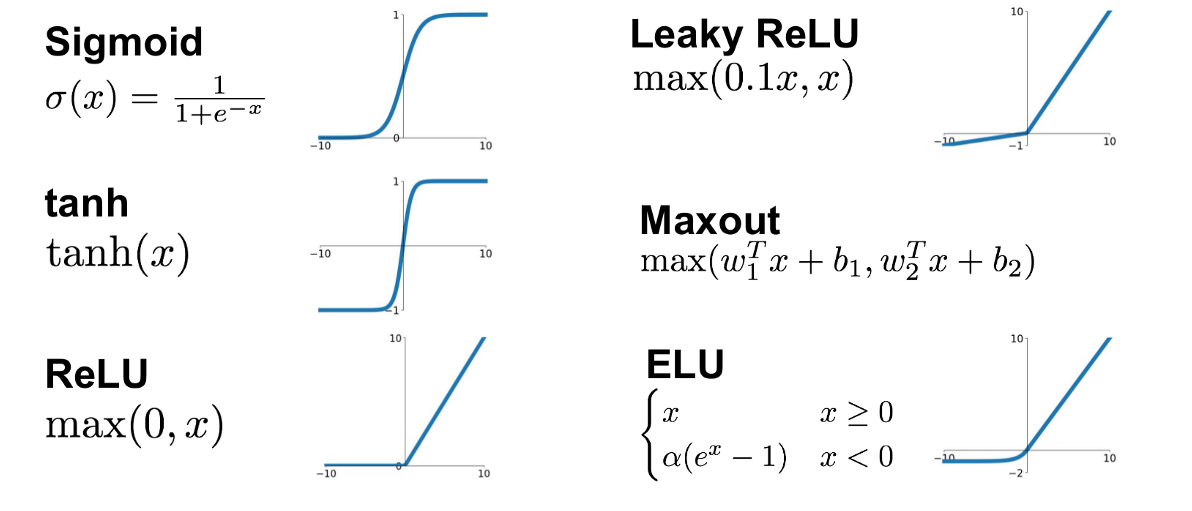

## Relu

The main advantage of using the ReLU function over other activation functions is that **it does not activate all the neurons at the same time.**

This means that the neurons will only **be deactivated if the output of the linear transformation is less than 0.**

I'll use Relu activation function in every layer except in the output layer.

Comparing Relu to Sigmoid, one major benefit is the reduced likelihood of the gradient to vanish. This arises when x>0. In this regime the gradient has a constant value. In contrast, the gradient of sigmoids becomes increasingly small as the absolute value of x increases. The constant gradient of ReLUs results in faster learning.

**Relu** is preferable for hidden layers (or Leaky Relu for instance).

## Sigmoid and Tanh

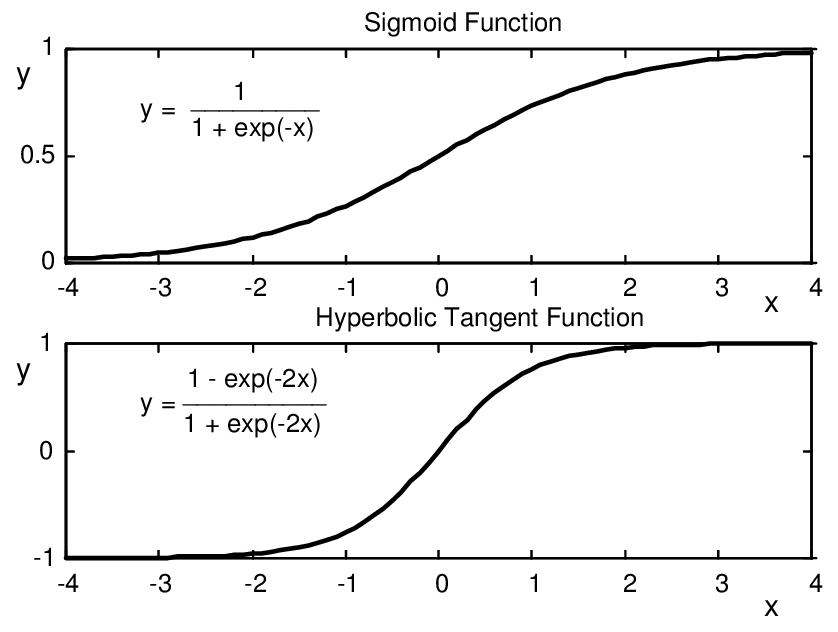

Sigmoid activation function translates the input ranged in (-inf,+inf) to the range in (0; 1), while tanh does it to the range in (-1;1). 

The derivatives of the tanh are larger than the derivatives of the sigmoid. In other words, you minimize your cost function faster if you use tanh as an activation fuction. I'll use tanh function for the output layer.

## Dropout

It’s a regularizer technique that **reduces the odds of overfitting by dropping out neurons at random, during every epoch** (or, when using a minibatch approach, during every minibatch). I'll use this in every layer.

## Hidden layers

This NN will have an input layer, 3 hidden layers and an output layer. As the number of nodes in each layer, the number of layers is another hyperparameter you should iterate over and check accuracy.

In [29]:
classifier.add(Dense(units = 7, activation='relu', kernel_initializer="glorot_uniform"))
classifier.add(Dropout(rate = 0.1))
classifier.add(Dense(units = 7, activation='relu', kernel_initializer="glorot_uniform"))
classifier.add(Dropout(rate = 0.1))
classifier.add(Dense(units = 7, activation='relu', kernel_initializer="glorot_uniform"))
classifier.add(Dropout(rate = 0.1))

## Output layer

In [30]:
classifier.add(Dense(units = 1, activation='tanh', kernel_initializer="uniform"))

## Compiling NN

In [31]:
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Optimizers

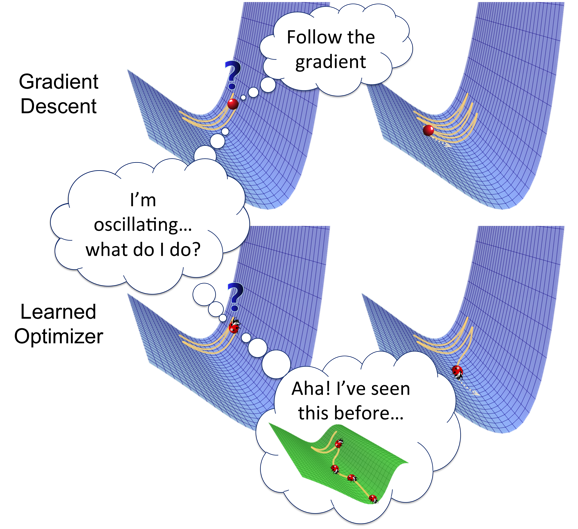

Optimizers are algorithms or methods used to **change the attributes of your neural network such as weights and learning rate in order to reduce the losses.** Some of them are:

**Gradient Descent** is the most basic but most used optimization algorithm. It’s used heavily in linear regression and classification algorithms. Backpropagation in neural networks also uses a gradient descent algorithm. Some disadvantages of this optimization algorithm are:

- Gradient Descent may trap at **local minima.**
- Weights are changed after calculating gradient on the **whole dataset.** So, if the dataset is too large than this may take years to converge to the minima.
- Requires large memory to calculate gradient on the whole dataset.

**Mini-Batch Gradient Descent** it’s best among all the variations of gradient descent algorithms. The dataset is divided into **various batches** and after every batch, the parameters are updated. It requires more computing power than gradient descent.

**Momentum** accelerates the **convergence towards the relevant direction** and reduces the fluctuation to the irrelevant direction. It reduces the oscillations and high variance of the parameters and converges faster than gradient descent.

**One more hyper-parameter** is added which needs to be selected manually and accurately.

**Adam** is a newer and improved optimizer. Its is an adaptive method compared to the gradient descent which maintains a single learning rate for all weight updates and the learning rate does not change.

Adam has the advantage over the GradientDescent of using the running average (momentum) of the gradients (mean) as well as the running average of the gradient squared. You can learn more in https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

## Loss function

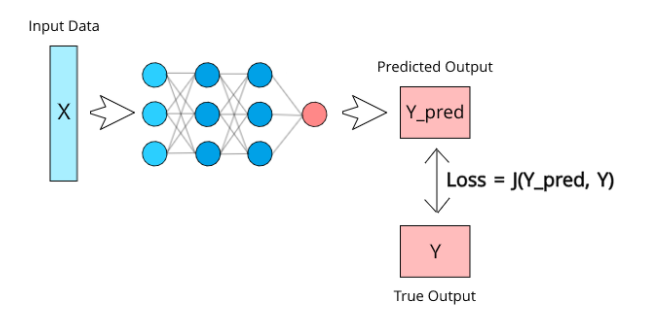

This function will essentially calculate **how poorly our model is performing by comparing what the model is predicting with the actual value it is supposed to output.** If Y_pred is very **far** off from Y, the Loss value will be **very high.** However if both values are almost **similar**, the Loss value will be **very low.**

This function will be different whether the problem is a regression or a classification for example. In this case, as we are trying to predict a class we'll be using binary cross entropy.

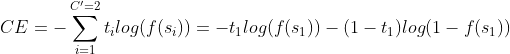

## Training the model

Now that we have explained all the layers, optimizers and function it's time to train the NN.

## Batch size and Epochs

- The **batch size** is a hyperparameter of gradient descent that controls the **number of training samples to work through before the model’s internal parameters are updated.**

- The number of **epochs** is a hyperparameter of gradient descent that controls the **number of complete passes through the training dataset.**

In [32]:
history = classifier.fit(X_train, y_train, batch_size=100, epochs=150)

Epoch 1/150
8000/8000 [==============================] - 1s 74us/step - loss: 0.6890 - accuracy: 0.7947
Epoch 2/150
8000/8000 [==============================] - 0s 18us/step - loss: 0.5435 - accuracy: 0.7947
Epoch 3/150
8000/8000 [==============================] - 0s 25us/step - loss: 0.5265 - accuracy: 0.7947
Epoch 4/150
8000/8000 [==============================] - 0s 26us/step - loss: 0.5136 - accuracy: 0.7947
Epoch 5/150
8000/8000 [==============================] - 0s 21us/step - loss: 0.5054 - accuracy: 0.7947
Epoch 6/150
8000/8000 [==============================] - 0s 27us/step - loss: 0.5009 - accuracy: 0.7947
Epoch 7/150
8000/8000 [==============================] - 0s 22us/step - loss: 0.4917 - accuracy: 0.7947
Epoch 8/150
8000/8000 [==============================] - 0s 21us/step - loss: 0.4872 - accuracy: 0.7946
Epoch 9/150
8000/8000 [==============================] - 0s 23us/step - loss: 0.4885 - accuracy: 0.7947
Epoch 10/150
8000/8000 [==============================] - 0s 17u

8000/8000 [==============================] - 0s 17us/step - loss: 0.3670 - accuracy: 0.8481
Epoch 78/150
8000/8000 [==============================] - 0s 16us/step - loss: 0.3677 - accuracy: 0.8481
Epoch 79/150
8000/8000 [==============================] - 0s 21us/step - loss: 0.3683 - accuracy: 0.8436
Epoch 80/150
8000/8000 [==============================] - 0s 26us/step - loss: 0.3677 - accuracy: 0.8472
Epoch 81/150
8000/8000 [==============================] - 0s 18us/step - loss: 0.3709 - accuracy: 0.8470
Epoch 82/150
8000/8000 [==============================] - 0s 19us/step - loss: 0.3693 - accuracy: 0.8449
Epoch 83/150
8000/8000 [==============================] - 0s 20us/step - loss: 0.3676 - accuracy: 0.8462
Epoch 84/150
8000/8000 [==============================] - 0s 17us/step - loss: 0.3704 - accuracy: 0.8462
Epoch 85/150
8000/8000 [==============================] - 0s 18us/step - loss: 0.3673 - accuracy: 0.8478
Epoch 86/150
8000/8000 [==============================] - 0s 20us/st

In [33]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5) # if y_pred is larger than 0.5 it returns true(1) else false(2)
y_pred

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [34]:
y_pred = y_pred.astype(int).reshape(X_test.shape[0])
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
Prediction_y = pd.DataFrame({'Prediction_y': y_pred})

Y = pd.DataFrame({'Y test': y_test}) # Df with real values and predicted values
Comparation = Y.join(Prediction_y) 
Comparation.sample(10)

Y test  Prediction_y
149      0.0             0
1860     0.0             0
924      0.0             0
1258     0.0             0
935      1.0             1
980      1.0             0
1641     0.0             0
849      0.0             0
1035     0.0             0
1217     0.0             0

## Confusion matrix

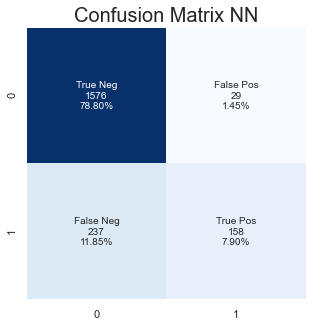

In [36]:
cm = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot = labels, fmt = '', cmap = 'Blues', cbar = False)
plt.gcf().set_size_inches(5, 5)
plt.title('Confusion Matrix NN', fontsize = 20)
plt.show()

## Metrics

In [37]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

Accuracy Score : 0.867
Precision Score : 0.8449197860962567
Recall Score : 0.4
F1 Score : 0.5429553264604811


## CAP curve

Cumulative Accuracy Profile curve is a tool that will help evaluate the performance and accuracy of the classification model.  I'll compare how CAP curves for NN algorithm relate to a random model and to an ideal model.

As the CAP curve gets more and more similar to the ideal model, the accuracy of the algorithm improves.

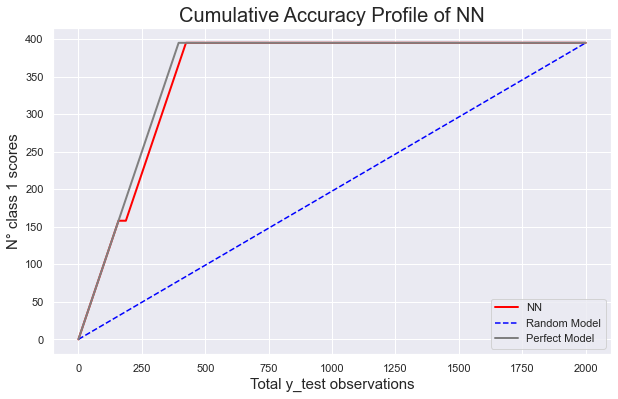

In [38]:
# length of the test data 
total = len(y_test) 
  
# Counting '1' labels in test data 
one_count = np.sum(y_test) 
  
# counting '0' lables in test data  
zero_count = total - one_count 

plt.figure(figsize = (10, 6)) 
  
# x-axis ranges from 0 to total people on y_test  
# y-axis ranges from 0 to the total positive outcomes. 

# NN classifier 

NN = [y for _, y in sorted(zip(y_pred, y_test), reverse = True)] 

x = np.arange(0, total + 1) # Shape of Y_test
y = np.append([0], np.cumsum(NN)) # Y values

plt.plot(x, y, c = 'red', label = 'NN', linewidth = 2)


# Random Model plot
  
plt.plot([0, total], [0, one_count], c = 'blue',  
         linestyle = '--', label = 'Random Model') 

# Perfect model plot

plt.plot([0, one_count, total], [0, one_count, one_count], 
         c = 'grey', linewidth = 2, label = 'Perfect Model') 

plt.title('Cumulative Accuracy Profile of NN', fontsize = 20)
plt.xlabel('Total y_test observations', fontsize = 15)
plt.ylabel('N° class 1 scores', fontsize = 15)
plt.legend() 
plt.show()

## AUC (Area Under the Curve)

In [39]:
# Area under Random Model
a = auc([0, total], [0, one_count])

# Area between Perfect and Random Model
aP = auc([0, one_count, total], [0, one_count, one_count]) - a

# Area XGClassifier

aNN = auc(x, y) - a
print("Accuracy Rate for NN: {}".format(aNN / aP))

Accuracy Rate for NN: 0.9783177570093458


As the NN has almost the same AUC as the perfect model, we have achieved a really accurate one.

## ROC curve

Receiver Operating Characteristic curve is another way to evaluate the accuracy of classification models and also to compare between them.

It plots the True Positive Rate in the Y-axis and False Positive Rate in the X-axis. It is a way to summarize information that could be obtained from many confusion matrices.

As the AUC gets bigger, the model is better at classifying.

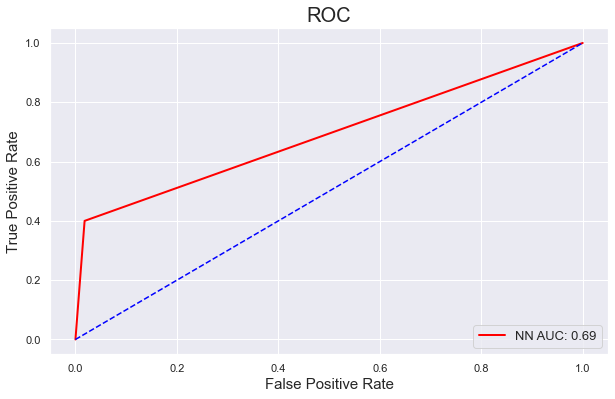

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10, 6)) 

plt.plot(fpr, tpr, c = 'red', linewidth = 2, label = 'NN AUC:' + ' {0:.2f}'.format(roc_auc))
plt.plot([0,1], [0,1], c = 'blue', linestyle = '--')

plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('ROC', fontsize = 20)
plt.legend(loc = 'lower right', fontsize = 13)
plt.show()

The ROC curve and AUC is not the best we could have, we should improve the recall to achieve a better model.